In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib 

In [ ]:
'''
For the old task, some data are contaminated:
click rule was actually intensity rule
'''
ALL = pd.read_csv("../Mante/ALL_6.4.25.csv").iloc[:,1:]
ALL = ALL.dropna()
subject_IDs = np.sort(ALL.subjects.unique())
# find the two tasks
INTENSITY = ALL[ALL.task == 24].reset_index(drop=True)
CLICKS = ALL[ALL.task == 29].reset_index(drop=True)

# Filter out the contaminated trials (approx. 500 trials)
INTENSITY = INTENSITY[500:]
CLICKS = CLICKS[500:]

In [ ]:
# sanity check if the two rules are correct in the filtered data
# should have only two unique stimuli for each actioni in each rule
I_right = INTENSITY.loc[
    INTENSITY['trial_types'] == 1, 
    'specific_stims'
].unique()
I_left = INTENSITY.loc[
    INTENSITY['trial_types'] == 0, 
    'specific_stims'
].unique()
print(I_right)
print(I_left)

CR_right = CLICKS.loc[
    CLICKS['trial_types'] == 1, 
    'specific_stims'
].unique()
CR_left = CLICKS.loc[
    CLICKS['trial_types'] == 0, 
    'specific_stims'
].unique()
print(CR_right)
print(CR_left)

['clicks_32hz_1s_60db.wav' 'clicks_12hz_1s_60db.wav']
['clicks_12hz_1s_70db.wav' 'clicks_32hz_1s_70db.wav']
['clicks_12hz_1s_60db.wav' 'clicks_12hz_1s_70db.wav']
['clicks_32hz_1s_70db.wav' 'clicks_32hz_1s_60db.wav']


In [ ]:
#                      I LOW 60 (RIGHT)           I HIGHT 70 (LEFT)        
# CR LOW 12 (RIGHT)     (context-invariant)       (context-dependent)
# CR HIGH 32 (LEFT)     (context-dependent)       (context-invariant)  

# the invariant stimuli are: 'clicks_12hz_1s_60db.wav', 'clicks_32hz_1s_70db.wav'
# the context-dependent stimuli are: 'clicks_12hz_1s_70db.wav', 'clicks_32hz_1s_60db.wav' 

In [ ]:
# load context-dependent and invariant trials for each task
INVARIANT_INTENSITY = INTENSITY[
    (INTENSITY['specific_stims'] == 'clicks_12hz_1s_60db.wav')
    | 
    (INTENSITY['specific_stims'] == 'clicks_32hz_1s_70db.wav')
]
DEPENDENT_INTENSITY = INTENSITY[
    (INTENSITY['specific_stims'] == 'clicks_12hz_1s_70db.wav')
    | 
    (INTENSITY['specific_stims'] == 'clicks_32hz_1s_60db.wav')
]

INVARIANT_CLICKS = CLICKS[
    (CLICKS['specific_stims'] == 'clicks_12hz_1s_60db.wav')
    | 
    (CLICKS['specific_stims'] == 'clicks_32hz_1s_70db.wav')
]
DEPENDENT_CLICKS = CLICKS[
    (CLICKS['specific_stims'] == 'clicks_12hz_1s_70db.wav')
    | 
    (CLICKS['specific_stims'] == 'clicks_32hz_1s_60db.wav')
]

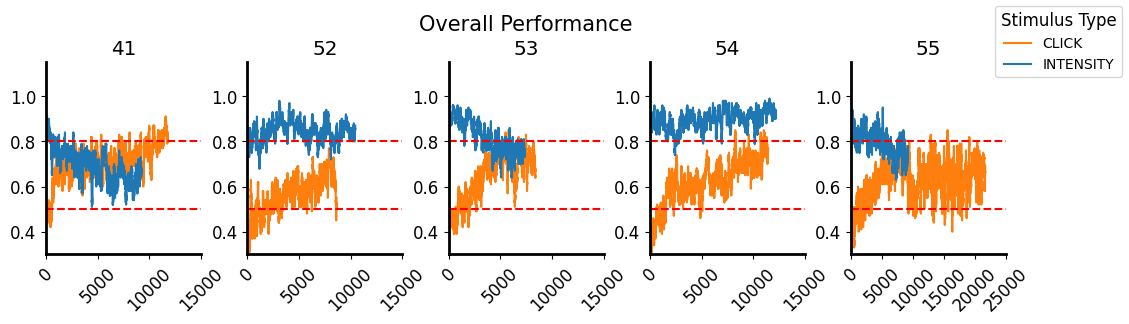

In [ ]:
# plot the overall performance in both tasks
fig = plt.figure(figsize=(12, 6))
roll_size = 100
import matplotlib 
import math
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    
    sub_clicks = CLICKS.loc[CLICKS.subjects == subject].reset_index(drop=True)
    sub_clicks.outcomes.rolling(roll_size).mean().plot(ax=ax,label="CLICK", color='#ff7f0e')
    sub_intensity = INTENSITY.loc[INTENSITY.subjects == subject].reset_index(drop=True)
    sub_intensity.outcomes.rolling(roll_size).mean().plot(ax=ax,label="INTENSITY", color='#1f77b4')
    plt.title(f'{str(subject)[-2:]}')
    idx += 1
    ax.axhline(0.8, color='red', ls='--')
    ax.axhline(0.5, color='red', ls='--')
    x_max = max(len(sub_intensity), len(sub_clicks))
    if x_max < 15000:
        lim_x = 15000
    else:
        lim_x = math.ceil(x_max / 5000) * 5000
    ax.set_xlim(0, lim_x) 
    ax.set_xticks(np.arange(0, lim_x+1, 5000))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))

    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Overall Performance', fontsize=15)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize = 10
)
plt.show()

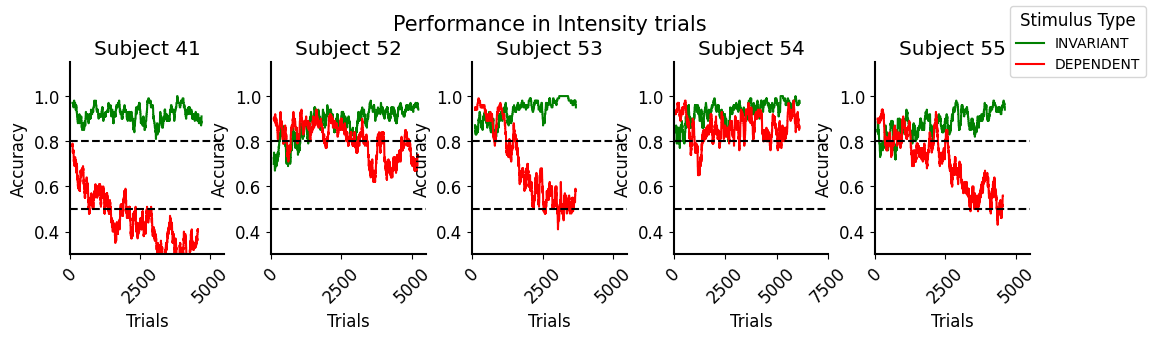

In [ ]:
# plot separately for context-dependent and -invariant stimuli in INTENSITY trials
fig = plt.figure(figsize=(12, 6))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    sub_inv_intensity = INVARIANT_INTENSITY.loc[INVARIANT_INTENSITY.subjects == subject].reset_index(drop=True)
    sub_inv_intensity.outcomes.rolling(100).mean().plot(ax=ax,label="INVARIANT", color='green')
    sub_dep_intensity = DEPENDENT_INTENSITY.loc[DEPENDENT_INTENSITY.subjects == subject].reset_index(drop=True)
    sub_dep_intensity.outcomes.rolling(100).mean().plot(ax=ax,label="DEPENDENT", color='red')
    plt.title(f'Subject {str(subject)[-2:]}')
    idx += 1
    ax.axhline(0.8, color='black', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    x_max = max(len(sub_inv_intensity), len(sub_dep_intensity))
    if x_max < 5500:
        lim_x = 5500
    else:
        lim_x = math.ceil(x_max / 2500) * 2500
    ax.set_xlim(0, lim_x) 
    ax.set_xticks(np.arange(0, lim_x+1, 2500))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trials')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Performance in Intensity trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize = 10
)
plt.show()

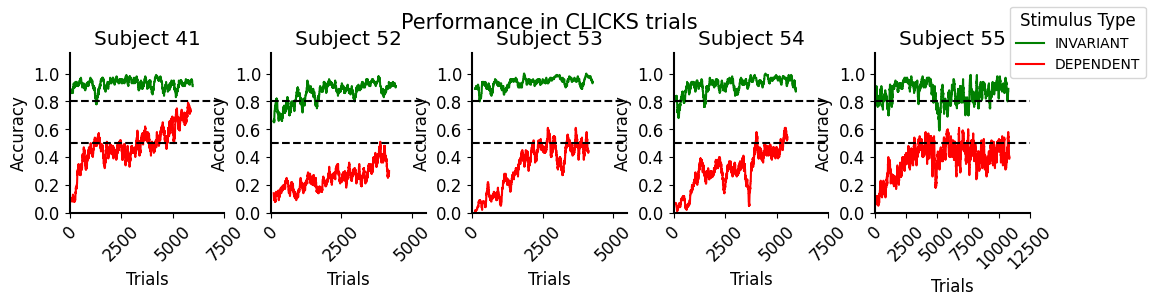

In [ ]:
# # plot separately for context-dependent and -invariant stimuli in CLICKS trials
fig = plt.figure(figsize=(12, 5))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    sub_inv_clicks = INVARIANT_CLICKS.loc[INVARIANT_CLICKS.subjects == subject].reset_index(drop=True)
    sub_inv_clicks.outcomes.rolling(100).mean().plot(ax=ax,label="INVARIANT", color='green')
    sub_dep_clicks = DEPENDENT_CLICKS.loc[DEPENDENT_CLICKS.subjects == subject].reset_index(drop=True)
    sub_dep_clicks.outcomes.rolling(100).mean().plot(ax=ax,label="DEPENDENT", color='red')
    plt.title(f'Subject {str(subject)[-2:]}')
    idx += 1
    ax.axhline(0.8, color='black', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    x_max = max(len(sub_inv_clicks), len(sub_dep_clicks))
    if x_max < 5500:
        lim_x = 5500
    else:
        lim_x = math.ceil(x_max / 2500) * 2500
    ax.set_xlim(0, lim_x) 
    ax.set_xticks(np.arange(0, lim_x+1, 2500))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_ylim(0, 1.15)  
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trials')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Performance in CLICKS trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize=10
)
plt.show()